# Project D4: Predicting LoL winner

Team members - Veronika Kukk, Robin Piir, Otto Kase
<br>Github - https://github.com/VeronikaKukk/DS_project 

# Gathering data

Data was gathered from Riot API by using development API key.
<br> Code for that is written in request_info.py.
<br> This gathering method has already removed any games that were less than 10 minutes and has only taken ranked games from players with rank Diamond I in ranked solo. 

In [1]:
# everything that needs to be imported (libraries)
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import numpy as np

# Model
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

# Combining data

To analyze servers we first need to combine files from those servers into one. This means that all of EUNE data will be in one dataframe and all of EUW data will be in one dataframe.

In [2]:
# import all eune files to dataframes
df_eune1 = pd.read_csv("eune_data1.csv", index_col=0)
df_eune2 = pd.read_csv("eune_data2.csv", index_col=0)
df_eune3 = pd.read_csv("eune_data3.csv", index_col=0)
df_eune4 = pd.read_csv("eune_data4.csv", index_col=0)

In [3]:
# import all euw files to dataframes
df_euw1 = pd.read_csv("euw_data1.csv", index_col=0)
df_euw2 = pd.read_csv("euw_data2.csv", index_col=0)
df_euw3 = pd.read_csv("euw_data3.csv", index_col=0)
df_euw4 = pd.read_csv("euw_data4.csv", index_col=0)

In [4]:
df_eune1

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,bluewins
0,EUN1_3250387583,118,4,1,4,3,5,0,0,0,...,14267,7.0,16956,193,72,8,-2314,21.436862,1584.661722,0
1,EUN1_3250345989,15,2,0,7,3,5,0,0,0,...,13815,6.4,15507,183,48,1397,893,20.325918,1534.440213,1
2,EUN1_3250132600,13,0,0,3,2,3,0,0,0,...,14202,7.0,17682,205,48,-544,-1343,22.768502,1577.357373,0
3,EUN1_3250109344,10,1,1,3,3,0,0,0,0,...,14684,6.6,16566,194,60,-541,111,21.549689,1631.111531,1
4,EUN1_3250074417,12,0,0,0,4,0,0,0,0,...,14784,6.6,16370,203,50,-2446,-2208,22.544534,1641.863978,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4063,EUN1_3241781223,112,1,1,12,4,10,1,0,1,...,14534,6.4,15108,175,52,3242,2265,19.439261,1614.458367,1
4064,EUN1_3241746052,17,5,1,13,6,20,0,0,0,...,15496,6.4,16230,195,64,3805,1745,21.659246,1721.188111,1
4065,EUN1_3241710887,16,1,0,3,9,3,0,0,0,...,17167,6.6,16519,171,56,-3654,-1748,18.995111,1906.953580,1
4066,EUN1_3241682864,34,1,0,4,7,2,0,0,0,...,14538,6.4,14915,171,36,568,1714,18.995181,1614.923621,0


In [5]:
# combining all of the dataframes of both servers into one
eune_dfs = [df_eune1, df_eune2, df_eune3, df_eune4]
euw_dfs = [df_euw1, df_euw2, df_euw3, df_euw4]

df_eune = pd.concat(eune_dfs, ignore_index=True)
df_euw = pd.concat(euw_dfs, ignore_index=True)

In [6]:
df_eune

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,bluewins
0,EUN1_3250387583,118,4,1,4,3,5,0,0,0,...,14267,7.0,16956,193,72,8,-2314,21.436862,1584.661722,0
1,EUN1_3250345989,15,2,0,7,3,5,0,0,0,...,13815,6.4,15507,183,48,1397,893,20.325918,1534.440213,1
2,EUN1_3250132600,13,0,0,3,2,3,0,0,0,...,14202,7.0,17682,205,48,-544,-1343,22.768502,1577.357373,0
3,EUN1_3250109344,10,1,1,3,3,0,0,0,0,...,14684,6.6,16566,194,60,-541,111,21.549689,1631.111531,1
4,EUN1_3250074417,12,0,0,0,4,0,0,0,0,...,14784,6.6,16370,203,50,-2446,-2208,22.544534,1641.863978,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16246,EUN1_3245368080,75,4,1,6,6,8,0,0,0,...,15542,6.6,16303,194,56,-509,-1744,21.549649,1726.415723,1
16247,EUN1_3245264423,9,3,0,1,6,1,0,0,0,...,14910,6.4,16199,185,40,-1725,-1144,20.548097,1656.065576,0
16248,EUN1_3245007949,14,0,0,4,7,5,0,0,0,...,14705,6.6,16327,164,56,-501,-496,18.216353,1633.362583,1
16249,EUN1_3244978461,11,1,0,0,9,0,0,0,0,...,15390,6.2,15396,169,44,-2950,-967,18.771764,1709.452342,0


In [7]:
df_euw

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,bluewins
0,EUW1_6141576712,13,0,0,2,8,1,0,0,0,...,17711,6.8,17142,231,50,-4725,-2951,25.657544,1967.189444,0
1,EUW1_6141532322,11,1,0,10,13,12,0,0,0,...,18593,6.4,16496,168,52,-788,127,18.661725,2065.341956,0
2,EUW1_6141500534,11,2,1,8,8,9,1,0,1,...,15676,6.2,15514,162,40,648,-1210,17.994502,1741.245730,1
3,EUW1_6141433343,16,4,0,8,7,7,0,0,0,...,15287,6.2,15702,198,36,1181,1308,21.994461,1698.127879,0
4,EUW1_6141410859,12,6,1,4,8,2,0,0,0,...,17163,6.8,17342,218,52,-2724,-1242,24.216930,1906.583376,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15978,EUW1_6066115292,13,4,1,11,6,10,0,0,0,...,14745,6.2,14569,137,40,3023,1524,15.217037,1637.775277,0
15979,EUW1_6064645200,16,0,1,20,6,14,0,0,0,...,14590,5.8,14197,141,43,6159,4105,15.662519,1620.681931,1
15980,EUW1_6064572344,11,1,0,7,9,10,0,0,0,...,15766,6.6,16694,199,48,1619,-109,22.106199,1751.388580,1
15981,EUW1_6064260946,12,1,0,5,7,6,0,0,0,...,15865,6.6,16212,195,53,-1194,-2290,21.659206,1762.170808,0


Before moving on to the next step, we decided to change the last columns name. Before it was called "bluewins" but for it to have the same style as the other columns, we changed it to "blueWins".

In [8]:
# changing the name of a column
df_eune.rename(columns={'bluewins': 'blueWins'}, inplace=True)
df_euw.rename(columns={'bluewins': 'blueWins'}, inplace=True)

In [9]:
df_eune

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
0,EUN1_3250387583,118,4,1,4,3,5,0,0,0,...,14267,7.0,16956,193,72,8,-2314,21.436862,1584.661722,0
1,EUN1_3250345989,15,2,0,7,3,5,0,0,0,...,13815,6.4,15507,183,48,1397,893,20.325918,1534.440213,1
2,EUN1_3250132600,13,0,0,3,2,3,0,0,0,...,14202,7.0,17682,205,48,-544,-1343,22.768502,1577.357373,0
3,EUN1_3250109344,10,1,1,3,3,0,0,0,0,...,14684,6.6,16566,194,60,-541,111,21.549689,1631.111531,1
4,EUN1_3250074417,12,0,0,0,4,0,0,0,0,...,14784,6.6,16370,203,50,-2446,-2208,22.544534,1641.863978,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16246,EUN1_3245368080,75,4,1,6,6,8,0,0,0,...,15542,6.6,16303,194,56,-509,-1744,21.549649,1726.415723,1
16247,EUN1_3245264423,9,3,0,1,6,1,0,0,0,...,14910,6.4,16199,185,40,-1725,-1144,20.548097,1656.065576,0
16248,EUN1_3245007949,14,0,0,4,7,5,0,0,0,...,14705,6.6,16327,164,56,-501,-496,18.216353,1633.362583,1
16249,EUN1_3244978461,11,1,0,0,9,0,0,0,0,...,15390,6.2,15396,169,44,-2950,-967,18.771764,1709.452342,0


# Cleaning data

In [10]:
# Find whether any games have no values
eune_nan = df_eune.isna().any(axis=1).sum()
euw_nan = df_euw.isna().any(axis=1).sum()
print("Number of missing values in EUNE: "+str(eune_nan))
print("Number of missing values in EUW: "+str(euw_nan))

Number of missing values in EUNE: 0
Number of missing values in EUW: 0


This means that there are no rows with missing values. No need to remove any rows because of this.

### Inspecting the mean, min and max

In [11]:
# Since we want to see all columns, we set the max_columns to None
pd.set_option('display.max_columns', None)
df_eune.describe()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
count,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000
mean,18.836133,2.004800,0.507353,5.689373,5.608455,5.698542,0.231309,0.063319,0.294628,0.005723,15048.074765,6.424122,15819.147745,184.409267,49.018276,-25.933727,9.856624,20.483711,1671.511804,20.082580,1.858163,0.492339,5.608455,5.689373,5.600886,0.250200,0.052181,0.302381,0.003631,15022.141037,6.427518,15829.004369,184.466925,49.935758,25.933727,-9.856624,20.490175,1668.638380,0.497692
std,20.162360,1.893432,0.499961,2.754621,2.726233,3.655421,0.421682,0.243544,0.482896,0.090967,1392.833911,0.276308,984.021891,19.627546,8.725882,2123.597085,1514.104666,2.179396,154.572394,23.552415,1.802871,0.499957,2.726233,2.754621,3.638016,0.433141,0.222400,0.489024,0.060146,1390.165646,0.278078,989.563015,19.663797,8.792196,2123.597085,1514.104666,2.183397,154.298370,0.500010
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4721.000000,2.200000,2800.000000,24.000000,0.000000,-12993.000000,-10601.000000,4.239596,833.963875,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5926.000000,2.800000,4065.000000,32.000000,0.000000,-8473.000000,-9779.000000,5.220192,873.438107,0.000000
25%,11.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14083.000000,6.200000,15193.000000,172.000000,44.000000,-1427.000000,-976.000000,19.104637,1564.413259,11.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14031.000000,6.200000,15207.000000,172.000000,44.000000,-1391.500000,-997.500000,19.104389,1558.544699,0.000000
50%,13.000000,2.000000,1.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,14952.000000,6.400000,15836.000000,185.000000,48.000000,-29.000000,-1.000000,20.549086,1660.798187,13.000000,2.000000,0.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,14923.000000,6.400000,15848.000000,185.000000,49.000000,29.000000,1.000000,20.549999,1657.582535,0.000000
75%,16.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,15906.000000,6.600000,16473.500000,198.000000,55.000000,1391.500000,997.500000,21.992628,1766.736371,16.000000,3.000000,1.000000,7.000000,7.000000,8.000000,1.000000,0.000000,1.000000,0.000000,15898.000000,6.600000,16478.500000,198.000000,56.000000,1427.000000,976.000000,21.993707,1765.846019,1.000000
max,306.000000,25.000000,1.000000,21.000000,23.000000,32.000000,1.000000,1.000000,2.000000,6.000000,25217.000000,7.400000,19705.000000,250.000000,84.000000,8473.000000,9779.000000,27.766209,2801.115988,341.000000,24.000000,1.000000,23.000000,21.000000,31.000000,1.000000,1.000000,2.000000,1.000000,21854.000000,7.400000,19218.000000,247.000000,84.000000,12993.000000,10601.000000,27.437636,2427.305240,1.000000


In [12]:
df_euw.describe()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
count,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.00000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000
mean,18.586060,2.101420,0.499656,5.650504,5.659200,5.863480,0.199087,0.101233,0.300319,0.007821,15140.575799,6.418833,15799.585497,187.651818,49.448727,18.022211,35.439029,20.843825,1681.767174,20.507039,1.971032,0.500156,5.659200,5.650504,5.955703,0.247200,0.080773,0.327973,0.005381,15158.59801,6.426666,15835.024526,188.122881,50.059939,-18.022211,-35.439029,20.896003,1683.759241,0.488081
std,19.465543,1.898543,0.500016,2.828800,2.811438,3.781927,0.399326,0.301646,0.492623,0.089501,1426.619092,0.283061,1006.155446,19.693728,9.006706,2171.882669,1524.580023,2.187890,158.491660,22.181218,1.827836,0.500016,2.811438,2.828800,3.857480,0.431398,0.272495,0.506667,0.085025,1425.33718,0.276972,984.703982,19.612040,9.084871,2171.882669,1524.580023,2.177910,158.228732,0.499874
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8787.000000,3.800000,6701.000000,40.000000,0.000000,-10075.000000,-7154.000000,4.443268,973.522798,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10722.00000,4.400000,9618.000000,96.000000,0.000000,-12288.000000,-10667.000000,10.662500,1190.870217,0.000000
25%,12.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14146.500000,6.200000,15174.500000,175.000000,44.000000,-1394.000000,-944.000000,19.438973,1571.242390,12.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14146.00000,6.200000,15222.000000,175.000000,44.000000,-1424.500000,-1007.500000,19.439459,1571.335744,0.000000
50%,13.000000,2.000000,0.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,15049.000000,6.400000,15827.000000,189.000000,48.000000,15.000000,28.000000,20.990166,1671.544643,14.000000,2.000000,1.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,15060.00000,6.400000,15857.000000,189.000000,49.000000,-15.000000,-28.000000,20.991720,1672.886816,0.000000
75%,16.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,16024.000000,6.600000,16473.000000,201.000000,56.000000,1424.500000,1007.500000,22.326718,1779.815868,17.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,16043.50000,6.600000,16494.500000,201.000000,56.000000,1394.000000,944.000000,22.328289,1782.072087,1.000000
max,286.000000,27.000000,1.000000,20.000000,22.000000,31.000000,1.000000,1.000000,2.000000,2.000000,22334.000000,7.400000,19501.000000,256.000000,88.000000,12288.000000,10667.000000,28.437809,2480.949101,295.000000,25.000000,1.000000,22.000000,20.000000,34.000000,1.000000,1.000000,2.000000,5.000000,24040.00000,7.400000,19906.000000,266.000000,84.000000,10075.000000,7154.000000,28.769839,2580.772955,1.000000


We found an anomaly with WardsPlaced (for both teams and both servers). It is unlikely that a team places more than ~X wards before 10 minutes, so we investigated why it is like that.
Our first thought was that it is possible that Riot counts some player abilities as wards, because those abilities give vison to the player.

In [13]:
# Finding the matchId
df_euw.loc[df_euw["blueWardsPlaced"]==286]

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
8525,EUW1_6131485050,286,0,0,3,6,1,0,0,0,0,14055,6.6,17259,185,53,677,-738,20.548858,1561.157845,14,1,1,6,3,5,0,0,0,0,14732,6.4,16521,191,49,-677,738,21.215308,1636.355558,1


In [14]:
# Finding the matchId
df_eune.loc[df_eune["blueWardsPlaced"]==306]

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
13825,EUN1_3249937829,306,2,1,2,6,1,0,0,0,0,13234,6.4,15712,187,42,1272,923,20.771585,1470.006165,10,14,0,6,2,3,0,0,0,0,14506,6.8,16635,180,41,-1272,-923,19.994039,1611.297372,1


We manualy searched through about 10 games that appeared in our dataset, which have more than 200 wards by either team. Riot marks most of the wards by one character (Warwick) as UNDEFINED.

In [15]:
# Finding matchId-s to check participating characters in the game
df_eune[(df_eune["blueWardsPlaced"] > 200) | (df_eune["redWardsPlaced"] > 200)]

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
265,EUN1_3246750364,8,1,1,4,6,2,0,0,0,0,13965,6.4,15582,185,48,1268,1161,20.551750,1551.379374,209,1,0,6,4,7,1,0,1,0,15233,6.6,16743,185,48,-1268,-1161,20.551750,1692.242177,1
342,EUN1_3226042360,207,14,1,2,6,0,0,0,0,0,13474,6.4,15881,190,48,1119,696,21.103764,1496.590076,32,2,0,6,2,7,1,0,1,0,14593,6.6,16577,169,56,-1119,-696,18.771243,1620.880138,0
344,EUN1_3217937111,214,1,0,2,6,2,0,0,0,0,13838,6.4,14936,198,38,1011,485,21.994705,1537.185492,10,1,1,6,2,10,1,0,1,0,14849,6.4,15421,179,62,-1011,-485,19.884102,1649.491789,0
600,EUN1_3250239128,33,3,1,4,6,3,0,1,1,0,14305,6.4,15660,158,52,927,169,17.551395,1589.067777,244,2,0,6,4,6,1,0,1,0,15232,6.4,15829,177,60,-927,-169,19.662006,1692.043367,0
1063,EUN1_3245723176,11,2,0,5,7,6,0,0,0,0,14831,6.4,14821,205,25,668,-465,22.771537,1647.437369,252,1,1,7,5,7,0,0,0,0,15499,6.4,14356,165,32,-668,465,18.328310,1721.639254,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15055,EUN1_3226910291,30,0,1,8,6,18,0,0,0,0,15513,6.2,15094,164,48,-671,-804,18.217061,1723.178433,203,10,0,6,8,7,1,0,1,0,14842,5.8,14290,150,48,671,804,16.661946,1648.643995,1
15121,EUN1_3227333388,79,3,0,7,5,9,0,0,0,0,15947,6.4,16517,186,55,-1866,-2548,20.660086,1771.324689,275,3,1,5,7,8,1,0,1,0,14081,5.8,13969,157,36,1866,2548,17.438890,1564.057374,1
15403,EUN1_3181921263,11,2,1,5,2,2,1,0,1,0,14705,6.4,15995,186,55,-1065,509,20.658939,1633.277922,288,3,0,2,5,1,0,0,0,0,13640,6.6,16504,204,48,1065,-509,22.658191,1514.988838,1
15437,EUN1_3245114886,278,1,0,5,10,5,0,0,0,0,13620,6.2,14591,136,60,3784,1239,15.106160,1512.837459,12,2,1,10,5,7,0,0,0,0,17404,6.6,15830,197,40,-3784,-1239,21.881717,1933.144136,0


Since there are 162 champions in League of Legends and many of them have abilities that give vision, we decided that we will remove games from our dataset that have more than 50 wards placed by either team. We are aware that this could influence the machine learning algorithm, but we think that these characters skew the warding data too much so we have decided to leave out games with an unrealistic amount of wards.

In addition, we noticed that the Kaggle dataset (https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min) that we had as an inspiration has included those values that we will remove. 

In [16]:
# Number of games that have more than 50 wards by either team EUW
len(df_euw[(df_euw["blueWardsPlaced"] > 50) | (df_euw["redWardsPlaced"] > 50)])

1801

In [17]:
# Number of games that have more than 50 wards by either team EUNE
len(df_eune[(df_eune["blueWardsPlaced"] > 50) | (df_eune["redWardsPlaced"] > 50)])

1774

In [18]:
# Removing rows with too many wards EUW
df_euw = df_euw[(df_euw["blueWardsPlaced"] <= 50) & (df_euw["redWardsPlaced"] <= 50)]

In [19]:
# # Removing rows with too many wards EUNE
df_eune = df_eune[(df_eune["blueWardsPlaced"] <= 50) & (df_eune["redWardsPlaced"] <= 50)]

In [20]:
print(len(df_eune))
print(len(df_euw))

14477
14182


The data can still include some duplicate values (games) because players from the same server and similar rank play together in ranked games.

### Removing duplicate values

We are counting unique matchId-s because each game has its own id.

In [21]:
print("EUNE game count: " + str(len(df_eune)))
print("EUNE unique game count: " +str(len(df_eune["matchId"].drop_duplicates())))

EUNE game count: 14477
EUNE unique game count: 13165


In [22]:
print("EUW game count: " + str(len(df_euw)))
print("EUW unique game count: " +str(len(df_euw["matchId"].drop_duplicates())))

EUW game count: 14182
EUW unique game count: 13508


In [23]:
df_eune = df_eune.drop_duplicates()
df_euw = df_euw.drop_duplicates()

### Balancing the dataset

It is not possible to have a tie. This means that either blue or red team has to win.

Counting how many blue wins (same as red loses) and loses (same as red wins) each server has, to determine how to balance data.

In [24]:
eune_bluewin_amount = len(df_eune[df_eune["blueWins"]==1])
eune_bluelose_amount = len(df_eune[df_eune["blueWins"]==0])
print("EUNE blue wins: ", eune_bluewin_amount)
print("EUNE blue loses (red wins): ", eune_bluelose_amount)

EUNE blue wins:  6493
EUNE blue loses (red wins):  6672


In [25]:
euw_bluewin_amount = len(df_euw[df_euw["blueWins"]==1])
euw_bluelose_amount = len(df_euw[df_euw["blueWins"]==0])
print("EUW blue wins: ", euw_bluewin_amount)
print("EUW blue loses (red wins): ", euw_bluelose_amount)

EUW blue wins:  6595
EUW blue loses (red wins):  6913


We are using random undersampling because we only want to have unique games. 

First we find the minimum of winning and losing games and then the minimum out of those. This is because we want both servers to have the same amount of positive and negative outcomes. There is no need to take the wins or losses into account when comparing the servers, so this balance will not influence the comparisons.

In [26]:
bluewins_amount = min(eune_bluewin_amount,euw_bluewin_amount)
blueloses_amount = min(eune_bluelose_amount, euw_bluelose_amount)
game_amount = min(bluewins_amount,blueloses_amount)

In [27]:
# replace=False is default, this means that there will be no duplicate values
eune_bluewins = df_eune[df_eune["blueWins"]==1].sample(n=game_amount, random_state=0)
eune_blueloses = df_eune[df_eune["blueWins"]==0].sample(n=game_amount, random_state=0)
euw_bluewins = df_euw[df_euw["blueWins"]==1].sample(n=game_amount, random_state=0)
euw_blueloses = df_euw[df_euw["blueWins"]==0].sample(n=game_amount, random_state=0)

In [28]:
df_eune_balanced = pd.concat([eune_bluewins, eune_blueloses])

In [29]:
df_euw_balanced = pd.concat([euw_bluewins, euw_blueloses])

While searching for correlations (later in the notebook), we found that we have made a mistake in gathering data. The mistake was that blueGoldDiff and redGoldDiff, redExperienceDiff and blueExperienceDiff should be swapped. We found the mistake because it did not make sense that blue team having more gold negatively influences the blueWins column.
Since both of these pairs are additive inverse of each other, we can just multiply the data by -1.

In [30]:
df_eune_balanced["blueGoldDiff"] = df_eune_balanced["blueGoldDiff"].apply(lambda x: x*-1)
df_eune_balanced["redGoldDiff"] = df_eune_balanced["redGoldDiff"].apply(lambda x: x*-1)
df_eune_balanced["blueExperienceDiff"] = df_eune_balanced["blueExperienceDiff"].apply(lambda x: x*-1)
df_eune_balanced["redExperienceDiff"] = df_eune_balanced["redExperienceDiff"].apply(lambda x: x*-1)

In [31]:
df_euw_balanced["blueGoldDiff"] = df_euw_balanced["blueGoldDiff"].apply(lambda x: x*-1)
df_euw_balanced["redGoldDiff"] = df_euw_balanced["redGoldDiff"].apply(lambda x: x*-1)
df_euw_balanced["blueExperienceDiff"] = df_euw_balanced["blueExperienceDiff"].apply(lambda x: x*-1)
df_euw_balanced["redExperienceDiff"] = df_euw_balanced["redExperienceDiff"].apply(lambda x: x*-1)

# Data after cleaning

We have removed duplicate values, removed some extreme values and balanced the data for both servers.

In [32]:
df_eune_balanced.describe()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
count,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000
mean,15.185815,1.985831,0.509703,5.692515,5.609657,5.717465,0.231326,0.062914,0.294240,0.005621,15044.353766,6.424411,15820.169182,184.321500,49.092946,19.948791,-13.392269,20.473970,1671.101660,15.185584,1.843909,0.489912,5.609657,5.692515,5.594409,0.246650,0.051902,0.298552,0.003234,15024.404975,6.428415,15833.561451,184.698598,49.980671,-19.948791,13.392269,20.515932,1668.894867,0.500000
std,7.703670,1.878386,0.499925,2.762269,2.717027,3.686067,0.421697,0.242817,0.481999,0.091448,1399.770990,0.277197,986.406412,19.642576,8.695388,2128.127924,1514.758917,2.180867,155.308519,7.685615,1.793983,0.499917,2.717027,2.762269,3.633528,0.431078,0.221838,0.487622,0.056781,1388.543505,0.277948,989.451356,19.654898,8.730237,2128.127924,1514.758917,2.182203,154.088463,0.500019
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4721.000000,2.200000,2800.000000,24.000000,0.000000,-8473.000000,-9779.000000,4.239596,833.963875,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5926.000000,2.800000,4065.000000,32.000000,0.000000,-12346.000000,-7256.000000,5.652795,1046.826927,0.000000
25%,11.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14070.250000,6.200000,15195.250000,172.000000,44.000000,-1399.750000,-997.000000,19.104318,1562.910927,11.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14033.000000,6.200000,15205.000000,172.000000,44.000000,-1427.750000,-977.000000,19.104752,1558.787782,0.000000
50%,13.000000,2.000000,1.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,14945.000000,6.400000,15842.000000,185.000000,48.000000,30.000000,-3.000000,20.548706,1660.098810,13.000000,2.000000,0.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,14921.000000,6.400000,15853.000000,185.000000,50.000000,-30.000000,3.000000,20.551807,1657.338889,0.500000
75%,15.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,15909.750000,6.600000,16477.000000,198.000000,56.000000,1427.750000,977.000000,21.992343,1767.144589,15.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,15895.750000,6.600000,16482.000000,198.000000,56.000000,1399.750000,997.000000,21.994379,1765.632919,1.000000
max,50.000000,25.000000,1.000000,20.000000,23.000000,32.000000,1.000000,1.000000,2.000000,6.000000,25217.000000,7.400000,19082.000000,250.000000,84.000000,12346.000000,7256.000000,27.766209,2801.115988,50.000000,24.000000,1.000000,23.000000,20.000000,30.000000,1.000000,1.000000,2.000000,1.000000,21854.000000,7.400000,19218.000000,247.000000,84.000000,8473.000000,9779.000000,27.437636,2427.305240,1.000000


In [33]:
df_eune_balanced.shape

(12986, 40)

In [34]:
df_euw_balanced.describe()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
count,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.00000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000
mean,15.276298,2.096489,0.498614,5.688973,5.651240,5.906284,0.202988,0.101263,0.304251,0.008548,15157.354074,6.421438,15810.835900,187.742569,49.486139,8.135531,-10.937163,20.853922,1683.635954,15.563992,1.960804,0.501155,5.651240,5.688973,5.943170,0.244032,0.080779,0.324811,0.005236,15149.218543,6.42361,15821.773063,188.164485,49.992684,-8.135531,10.937163,20.900703,1682.726447,0.500000
std,7.449993,1.899154,0.500017,2.846622,2.815949,3.786271,0.402239,0.301688,0.494319,0.092894,1432.495540,0.282422,1001.780278,19.655474,8.984786,2181.976944,1525.285752,2.183499,159.137590,7.690406,1.814863,0.500018,2.815949,2.846622,3.868896,0.429528,0.272506,0.505186,0.083088,1427.955115,0.27761,986.153431,19.574296,9.107624,2181.976944,1525.285752,2.173785,158.575402,0.500019
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9322.000000,3.800000,6701.000000,50.000000,0.000000,-12288.000000,-9405.000000,5.554146,973.522798,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10722.000000,4.40000,9618.000000,96.000000,0.000000,-10075.000000,-7154.000000,10.662500,1190.870217,0.000000
25%,11.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14156.000000,6.200000,15186.000000,175.000000,44.000000,-1400.000000,-987.000000,19.439090,1572.423445,12.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14133.000000,6.20000,15205.000000,175.000000,44.000000,-1425.000000,-964.000000,19.440214,1569.841872,0.000000
50%,13.000000,2.000000,0.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,15066.500000,6.400000,15839.000000,189.000000,48.000000,7.000000,-1.500000,20.992167,1673.610578,13.000000,2.000000,1.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,15043.000000,6.40000,15846.000000,189.000000,49.000000,-7.000000,1.500000,20.992264,1671.070001,0.500000
75%,16.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,16044.000000,6.600000,16481.000000,201.000000,56.000000,1425.000000,964.000000,22.327173,1782.132582,16.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,16041.750000,6.60000,16474.000000,201.000000,56.000000,1400.000000,987.000000,22.329033,1781.878789,1.000000
max,50.000000,27.000000,1.000000,20.000000,21.000000,31.000000,1.000000,1.000000,2.000000,2.000000,22334.000000,7.400000,19501.000000,256.000000,88.000000,10075.000000,7154.000000,28.437809,2480.949101,50.000000,25.000000,1.000000,21.000000,20.000000,34.000000,1.000000,1.000000,2.000000,5.000000,23235.000000,7.40000,19906.000000,266.000000,84.000000,12288.000000,9405.000000,28.769839,2580.772955,1.000000


In [35]:
df_euw_balanced.shape

(12986, 40)

In [36]:
# Write data to csv files 
filepath1 = Path('clean_eune.csv')
filepath2 = Path('clean_euw.csv')
df_eune_balanced.to_csv(filepath1)
df_euw_balanced.to_csv(filepath2)

# Correlations between game data and match result

It is likely that different servers have different playstyles. This means that we cannot combine those servers while searching for correlations. Both servers will be investigated separately.

### EUNE correlations

Text(0.5, 1.0, 'EUNE correlations')

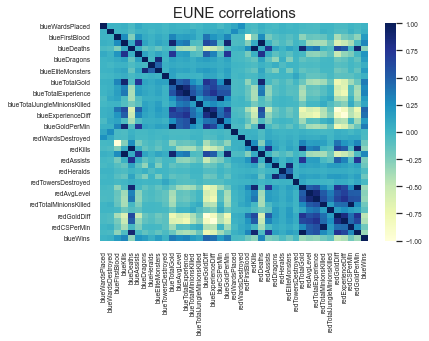

In [37]:
eune_corr_matrix = df_eune_balanced.corr()
# There are too many attributes, so the font needs to be quite small
sns.set(font_scale=0.6)
sns.heatmap(eune_corr_matrix,cmap="YlGnBu")
plt.title("EUNE correlations", fontsize=15)

Since our goal is to find correlations between game data and match result (blueWins), we only look at blueWins column from the matrix. 

In [38]:
# Sorting blueWins column correlations by descending
abs(eune_corr_matrix["blueWins"]).sort_values(ascending=False)

blueWins                        1.000000
blueGoldDiff                    0.463782
redGoldDiff                     0.463782
redExperienceDiff               0.413971
blueExperienceDiff              0.413971
blueGoldPerMin                  0.358372
blueTotalGold                   0.358169
redGoldPerMin                   0.350298
redTotalGold                    0.349742
blueTotalExperience             0.318804
redTotalExperience              0.315929
redDeaths                       0.301064
blueKills                       0.301064
redKills                        0.291282
blueDeaths                      0.291282
redAvgLevel                     0.282660
blueAvgLevel                    0.274980
blueAssists                     0.234136
redAssists                      0.230824
redCSPerMin                     0.194815
redTotalMinionsKilled           0.194633
blueTotalMinionsKilled          0.187326
blueCSPerMin                    0.187322
blueFirstBlood                  0.184695
redFirstBlood   

As expected, blueGoldDiff and redGoldDiff, redExperienceDiff and blueExperienceDiff, redDeaths and blueKills, redKills and blueDeaths all have the same correlation in pairs, because they are either additive inverse of the other or the same.

Text(0.5, 1.0, 'EUNE correlations between game data and match result')

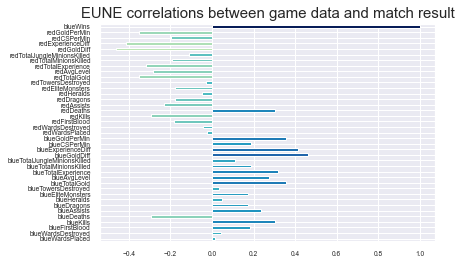

In [39]:
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
colors = [plt.cm.YlGnBu(norm(c)) for c in eune_corr_matrix["blueWins"].values]
eune_corr_matrix["blueWins"].plot.barh(color=colors)
plt.title("EUNE correlations between game data and match result", fontsize=15)

### EUW correlations

We do the exact sames steps for EUW as we have done for EUNE

Text(0.5, 1.0, 'EUW correlations')

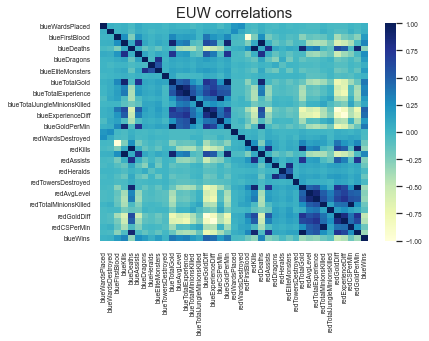

In [40]:
euw_corr_matrix = df_euw_balanced.corr()
sns.heatmap(euw_corr_matrix, cmap="YlGnBu")
plt.title("EUW correlations", fontsize=15)

In [41]:
# Sorting blueWins column correlations by descending
abs(euw_corr_matrix["blueWins"]).sort_values(ascending=False)

blueWins                        1.000000
redGoldDiff                     0.477467
blueGoldDiff                    0.477467
redExperienceDiff               0.423001
blueExperienceDiff              0.423001
blueTotalGold                   0.370142
blueGoldPerMin                  0.370117
redGoldPerMin                   0.358300
redTotalGold                    0.358272
blueTotalExperience             0.333556
redTotalExperience              0.315416
blueKills                       0.308266
redDeaths                       0.308266
redKills                        0.297677
blueDeaths                      0.297677
blueAvgLevel                    0.289797
redAvgLevel                     0.273460
blueAssists                     0.260644
redAssists                      0.251834
blueTotalMinionsKilled          0.192343
blueCSPerMin                    0.192338
blueFirstBlood                  0.181889
redFirstBlood                   0.181735
blueDragons                     0.179581
redTotalMinionsK

Text(0.5, 1.0, 'EUW correlations between game data and match result')

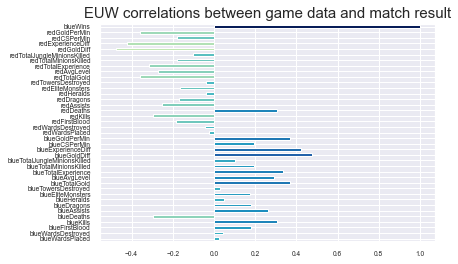

In [42]:
colors = [plt.cm.YlGnBu(norm(c)) for c in euw_corr_matrix["blueWins"].values]
euw_corr_matrix["blueWins"].plot.barh(color=colors)
plt.title("EUW correlations between game data and match result", fontsize=15)

### Something about correlations !!!

We notice, that for both servers in our dataset, gold and experience are the two attributes influencing the match result the most. On the other hand, according to the correlation plots placing or destroying wards and destroying towers have the least impact on the match result.

Visualy there is almost no difference between both server's correlation plots.

# Dividing data for models

First of all, let's define the features we will use for training our models, since using all of them is unnecessary due to some defining the others. (for example, blue kills defining red deaths, blueFirstBlood defining redFirstBlood etc.). Killing minions only provides gold and experience, so those columns are redundant aswell. \
We will drop the feature(s) we are not using.

In [43]:
drop = ['matchId']
df_euw_balanced = df_euw_balanced.drop(drop, axis=1)
df_eune_balanced = df_eune_balanced.drop(drop, axis=1)

Split up the data into training sets and test sets.

In [44]:
features_euw = df_euw_balanced.drop("blueWins",axis=1)
features_eune = df_eune_balanced.drop("blueWins",axis=1)

target_euw = df_euw_balanced["blueWins"]
target_eune = df_eune_balanced["blueWins"]

# We divide data into train 80%, test 10% and validation 10%
# EUW
X_train_euw, X_valtest_euw, y_train_euw, y_valtest_euw = train_test_split(features_euw, target_euw,test_size=0.2, random_state=0)
X_val_euw, X_test_euw, y_val_euw, y_test_euw = train_test_split(X_valtest_euw, y_valtest_euw, test_size=0.5, random_state=0)
# EUNE
X_train_eune, X_valtest_eune, y_train_eune, y_valtest_eune = train_test_split(features_eune,target_eune,test_size=0.2,random_state=0)
X_val_eune, X_test_eune, y_val_eune, y_test_eune = train_test_split(X_valtest_eune, y_valtest_eune, test_size=0.5, random_state=0)

In [45]:
X_train_eune

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
2535,38,3,1,6,0,9,1,0,1,0,16101,6.6,16598,203,48,4096,1057,22.550377,1788.589287,16,2,0,0,6,0,0,0,0,0,12005,6.2,15541,193,44,-4096,-1057,21.439521,1333.582659
5930,37,2,1,5,3,5,0,0,0,0,14751,6.6,16863,187,56,1285,139,20.768893,1638.299172,16,1,0,3,5,3,0,0,0,0,13466,7.0,16724,180,52,-1285,-139,19.991448,1495.582445
10227,26,1,0,3,3,2,1,0,1,0,13032,6.6,15599,152,56,-495,154,16.885355,1447.697056,8,3,1,3,3,3,0,0,0,0,13527,6.4,15445,186,40,495,-154,20.662343,1502.685549
641,11,0,1,3,9,5,0,0,0,0,14133,6.2,14940,215,38,-2702,-2517,23.881282,1569.833312,13,2,0,9,3,4,0,0,0,0,16835,7.0,17457,201,56,2702,2517,22.326222,1869.959939
529,17,3,0,6,10,5,1,0,1,0,16417,6.6,16415,200,48,674,616,22.215229,1823.537035,12,4,1,10,6,14,0,0,0,0,15743,6.6,15799,162,46,-674,-616,17.994335,1748.671714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13472,14,3,1,4,3,3,1,0,1,0,14971,6.6,16226,197,56,1262,795,21.883742,1663.053319,12,3,0,3,4,3,0,0,0,0,13709,6.2,15431,170,48,-1262,-795,18.884448,1522.864067
3316,14,2,0,4,4,3,1,0,1,0,14100,6.6,16576,185,60,-745,321,20.549809,1566.228703,15,3,1,4,4,5,0,0,0,0,14845,6.6,16255,197,56,745,-321,21.882770,1648.983340
14489,11,1,0,7,12,4,0,0,0,0,14658,5.8,14254,174,36,-2012,-530,19.328573,1628.265631,29,2,1,12,7,11,1,0,1,0,16670,6.4,14784,136,48,2012,530,15.107390,1851.766139
2608,17,1,1,5,8,6,0,0,0,0,14082,6.0,14647,179,32,-1058,-1722,19.882703,1564.180033,26,1,0,8,5,6,1,0,1,0,15140,6.6,16369,153,48,1058,1722,16.994713,1681.699027


In [46]:
y_train_eune

2535     1
5930     1
10227    1
641      0
529      0
        ..
13472    1
3316     1
14489    0
2608     0
7147     1
Name: blueWins, Length: 10388, dtype: int64

# Creating models

In [47]:
# Saving the accuracies of each model for future visualization and comparing
Accuracies_EUW = pd.DataFrame(columns=['model', 'accuracy'])
Accuracies_EUNE = pd.DataFrame(columns=['model', 'accuracy'])

### Linear Regression

As the first model, we decided to use LinearRegression, which is normally used for values that are not integers. We still decided to experiment and find out, how well it predicts.

In [48]:
# Creating the models
LinearRegression_model_EUW = LinearRegression()
LinearRegression_model_EUNE = LinearRegression()

# Training
LinearRegression_model_EUW.fit(X_train_euw, y_train_euw)
LinearRegression_model_EUNE.fit(X_train_eune, y_train_eune)

# Predicting
y_predicted_LinearRegression_EUW = LinearRegression_model_EUW.predict(X_test_euw)
y_predicted_LinearRegression_EUNE = LinearRegression_model_EUNE.predict(X_test_eune)

# Accuracy
Accuracy_LinearRegression_EUW = accuracy_score(y_test_euw, np.rint(y_predicted_LinearRegression_EUW))
Accuracy_LinearRegression_EUNE = accuracy_score(y_test_euw, np.rint(y_predicted_LinearRegression_EUNE))

Accuracies_EUW.append({'model': "LR_EUW", 'accuracy': Accuracy_LinearRegression_EUW }, ignore_index=True)
Accuracies_EUNE.append({'model': "LR_EUNE", 'accuracy': Accuracy_LinearRegression_EUNE }, ignore_index=True)

# Printing results
print("The accuracy of LinearRegression on the EUW server is %.4f." % Accuracy_LinearRegression_EUW)
print("The accuracy of LinearRegression on the EUNE server is %.4f." % Accuracy_LinearRegression_EUNE)

The accuracy of LinearRegression on the EUW server is 0.7221.
The accuracy of LinearRegression on the EUNE server is 0.7105.


C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\4270980775.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUW.append({'model': "LR_EUW", 'accuracy': Accuracy_LinearRegression_EUW }, ignore_index=True)
C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\4270980775.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUNE.append({'model': "LR_EUNE", 'accuracy': Accuracy_LinearRegression_EUNE }, ignore_index=True)


### K-nearest neighbors

The second model was chosen to be KNeighborsClassifier, which uses the k-nearest neighbors method to classify results. We decided to use the default number of neighbors (5).

In [49]:
# Creating the models
KNeighborsClassifier_model_EUW = KNeighborsClassifier()
KNeighborsClassifier_model_EUNE = KNeighborsClassifier()

# Training
KNeighborsClassifier_model_EUW.fit(X_train_euw, y_train_euw)
KNeighborsClassifier_model_EUNE.fit(X_train_eune, y_train_eune)

# Predicting
y_predicted_KNeighborsClassifier_EUW = KNeighborsClassifier_model_EUW.predict(X_test_euw)
y_predicted_KNeighborsClassifier_EUNE = KNeighborsClassifier_model_EUNE.predict(X_test_eune)

# Accuracy
Accuracy_KNeighborsClassifier_EUW = accuracy_score(y_test_euw, y_predicted_KNeighborsClassifier_EUW)
Accuracy_KNeighborsClassifier_EUNE = accuracy_score(y_test_euw, y_predicted_KNeighborsClassifier_EUNE)

Accuracies_EUW.append({'model': "KNN_EUW", 'accuracy': Accuracy_KNeighborsClassifier_EUW }, ignore_index=True)
Accuracies_EUNE.append({'model': "KNN_EUNE", 'accuracy': Accuracy_KNeighborsClassifier_EUNE }, ignore_index=True)

# Printing results
print("The accuracy of KNeighborsClassifier on the EUW server is %.4f." % Accuracy_KNeighborsClassifier_EUW)
print("The accuracy of KNeighborsClassifier on the EUNE server is %.4f." % Accuracy_KNeighborsClassifier_EUNE)

The accuracy of KNeighborsClassifier on the EUW server is 0.6605.
The accuracy of KNeighborsClassifier on the EUNE server is 0.6482.


C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\907725268.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUW.append({'model': "KNN_EUW", 'accuracy': Accuracy_KNeighborsClassifier_EUW }, ignore_index=True)
C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\907725268.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUNE.append({'model': "KNN_EUNE", 'accuracy': Accuracy_KNeighborsClassifier_EUNE }, ignore_index=True)


### Decision Tree classifier

First we try DecisionTreeClassifier with default parameters.

In [50]:
# Creating the models
DecisionTreeClassifier_model_EUW = DecisionTreeClassifier(random_state=0)
DecisionTreeClassifier_model_EUNE = DecisionTreeClassifier(random_state=0)

# Training
DecisionTreeClassifier_model_EUW.fit(X_train_euw, y_train_euw)
DecisionTreeClassifier_model_EUNE.fit(X_train_eune, y_train_eune)

# Predicting
y_predicted_DecisionTreeClassifier_EUW = DecisionTreeClassifier_model_EUW.predict(X_test_euw)
y_predicted_DecisionTreeClassifier_EUNE = DecisionTreeClassifier_model_EUNE.predict(X_test_eune)

# Accuracy
Accuracy_DecisionTreeClassifier_EUW = accuracy_score(y_test_euw,y_predicted_DecisionTreeClassifier_EUW)
Accuracy_DecisionTreeClassifier_EUNE = accuracy_score(y_test_eune,y_predicted_DecisionTreeClassifier_EUNE)

Accuracies_EUW.append({'model': "DTC_EUW", 'accuracy': Accuracy_DecisionTreeClassifier_EUW }, ignore_index=True)
Accuracies_EUNE.append({'model': "DTC_EUNE", 'accuracy': Accuracy_DecisionTreeClassifier_EUNE }, ignore_index=True)

print("The accuracy of DecisionTreeClassifier with default parameters on the EUW server is %.4f." % Accuracy_DecisionTreeClassifier_EUW)
print("The accuracy of DecisionTreeClassifier with default parameters on the EUNE server is %.4f." % Accuracy_DecisionTreeClassifier_EUNE)

The accuracy of DecisionTreeClassifier with default parameters on the EUW server is 0.6397.
The accuracy of DecisionTreeClassifier with default parameters on the EUNE server is 0.6166.


C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\3134433132.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUW.append({'model': "DTC_EUW", 'accuracy': Accuracy_DecisionTreeClassifier_EUW }, ignore_index=True)
C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\3134433132.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUNE.append({'model': "DTC_EUNE", 'accuracy': Accuracy_DecisionTreeClassifier_EUNE }, ignore_index=True)


To improve the prediction, we use hyperparameter tuning for DecisionTreeClassifier with RandomizedSearchCV.

In [51]:
# Defining the parameters that we will be tuning
# EUNE and EUW have the same amount of features, so it does not matter which one we use in max_features
parameters = {'criterion': ('gini','entropy'),
             'splitter':('best','random'),
              'max_depth': np.arange(1,100,1),
              'min_samples_split':np.arange(0,100,1),
              'min_samples_leaf': np.arange(2,100,1),
              'min_weight_fraction_leaf': np.arange(0,0.5,0.1),
              'max_features': np.arange(1,len(X_train_eune.columns),1),
             }
# Creating the models
grid_DecisionTreeClassifier_EUNE = RandomizedSearchCV(DecisionTreeClassifier(random_state=0), param_distributions=parameters, cv=100, verbose=1)
grid_DecisionTreeClassifier_EUW = RandomizedSearchCV(DecisionTreeClassifier(random_state=0), param_distributions=parameters, cv=100, verbose=1)

# Training
grid_DecisionTreeClassifier_EUNE.fit(X_train_eune,y_train_eune)
print("EUNE DecisionTreeClassifier best params: ",grid_DecisionTreeClassifier_EUNE.best_params_)
grid_DecisionTreeClassifier_EUW.fit(X_train_euw,y_train_euw)
print("EUW DecisionTreeClassifier best params: ",grid_DecisionTreeClassifier_EUW.best_params_)

# Predicting
y_predicted_grid_DecisionTreeClassifier_EUW = grid_DecisionTreeClassifier_EUW.predict(X_test_euw)
y_predicted_grid_DecisionTreeClassifier_EUNE = grid_DecisionTreeClassifier_EUNE.predict(X_test_eune)

# Accuracy
Accuracy_grid_DecisionTreeClassifier_EUW = accuracy_score(y_test_euw,y_predicted_grid_DecisionTreeClassifier_EUW)
Accuracy_grid_DecisionTreeClassifier_EUNE = accuracy_score(y_test_eune,y_predicted_grid_DecisionTreeClassifier_EUNE)

Accuracies_EUW.append({'model': "gDTC_EUW", 'accuracy': Accuracy_grid_DecisionTreeClassifier_EUW }, ignore_index=True)
Accuracies_EUNE.append({'model': "gDTC_EUNE", 'accuracy': Accuracy_grid_DecisionTreeClassifier_EUNE }, ignore_index=True)

print("The accuracy of DecisionTreeClassifier with parameter tuning on the EUW server is %.4f." % Accuracy_grid_DecisionTreeClassifier_EUW)
print("The accuracy of DecisionTreeClassifier with parameter tuning on the EUNE server is %.4f." % Accuracy_grid_DecisionTreeClassifier_EUNE)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits
EUNE DecisionTreeClassifier best params:  {'splitter': 'best', 'min_weight_fraction_leaf': 0.2, 'min_samples_split': 17, 'min_samples_leaf': 57, 'max_features': 36, 'max_depth': 40, 'criterion': 'entropy'}
Fitting 100 folds for each of 10 candidates, totalling 1000 fits
EUW DecisionTreeClassifier best params:  {'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 8, 'min_samples_leaf': 60, 'max_features': 30, 'max_depth': 44, 'criterion': 'gini'}
The accuracy of DecisionTreeClassifier with parameter tuning on the EUW server is 0.7121.
The accuracy of DecisionTreeClassifier with parameter tuning on the EUNE server is 0.6736.


C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\4092990353.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUW.append({'model': "gDTC_EUW", 'accuracy': Accuracy_grid_DecisionTreeClassifier_EUW }, ignore_index=True)
C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\4092990353.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUNE.append({'model': "gDTC_EUNE", 'accuracy': Accuracy_grid_DecisionTreeClassifier_EUNE }, ignore_index=True)


### Random Forest classifier

First we try RandomForestClassifier with default parameters.

In [52]:
# Creating the models
RandomForestClassifier_model_EUW = RandomForestClassifier(random_state=0)
RandomForestClassifier_model_EUNE = RandomForestClassifier(random_state=0)

# Training
RandomForestClassifier_model_EUW.fit(X_train_euw, y_train_euw)
RandomForestClassifier_model_EUNE.fit(X_train_eune, y_train_eune)

# Predicting
y_predicted_RandomForestClassifier_EUW = RandomForestClassifier_model_EUW.predict(X_test_euw)
y_predicted_RandomForestClassifier_EUNE = RandomForestClassifier_model_EUNE.predict(X_test_eune)

# Accuracy
Accuracy_RandomForestClassifier_EUW = accuracy_score(y_test_euw,y_predicted_RandomForestClassifier_EUW)
Accuracy_RandomForestClassifier_EUNE = accuracy_score(y_test_eune,y_predicted_RandomForestClassifier_EUNE)

Accuracies_EUW.append({'model': "RFC_EUW", 'accuracy': Accuracy_RandomForestClassifier_EUW }, ignore_index=True)
Accuracies_EUNE.append({'model': "RFC_EUNE", 'accuracy': Accuracy_RandomForestClassifier_EUNE }, ignore_index=True)

print("The accuracy of RandomForestClassifier with parameter tuning on the EUW server is %.4f." % Accuracy_RandomForestClassifier_EUW)
print("The accuracy of RandomForestClassifier with parameter tuning on the EUNE server is %.4f." % Accuracy_RandomForestClassifier_EUNE)

The accuracy of RandomForestClassifier with parameter tuning on the EUW server is 0.7044.
The accuracy of RandomForestClassifier with parameter tuning on the EUNE server is 0.6913.


C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\2621931091.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUW.append({'model': "RFC_EUW", 'accuracy': Accuracy_RandomForestClassifier_EUW }, ignore_index=True)
C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\2621931091.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUNE.append({'model': "RFC_EUNE", 'accuracy': Accuracy_RandomForestClassifier_EUNE }, ignore_index=True)


To improve the prediction, we use hyperparameter tuning for RandomForestClassifier with RandomizedSearchCV.

In [53]:
parameters = {'criterion': ('gini','entropy'),
              'max_depth': np.arange(1,100,1),
              'min_samples_split':np.arange(0,100,1),
              'min_samples_leaf': np.arange(2,100,1),
              'min_weight_fraction_leaf': np.arange(0,0.5,0.1),
              'max_features': np.arange(1,len(X_train_eune.columns),1),
             }
# Creating the models
grid_RandomForestClassifier_EUNE = RandomizedSearchCV(RandomForestClassifier(random_state=0), param_distributions=parameters, cv=10, verbose=1)
grid_RandomForestClassifier_EUW = RandomizedSearchCV(RandomForestClassifier(random_state=0), param_distributions=parameters, cv=10, verbose=1)

# Training
grid_RandomForestClassifier_EUNE.fit(X_train_eune,y_train_eune)
print("EUNE RandomForestClassifier best params: ",grid_RandomForestClassifier_EUNE.best_params_)
grid_RandomForestClassifier_EUW.fit(X_train_euw,y_train_euw)
print("EUW RandomForestClassifier best params: ",grid_RandomForestClassifier_EUW.best_params_)

# Predicting
y_predicted_RandomForestClassifier_EUW = grid_RandomForestClassifier_EUW.predict(X_test_euw)
y_predicted_RandomForestClassifier_EUNE = grid_RandomForestClassifier_EUNE.predict(X_test_eune)

# Accuracy
Accuracy_grid_RandomForestClassifier_EUW = accuracy_score(y_test_euw,y_predicted_RandomForestClassifier_EUW)
Accuracy_grid_RandomForestClassifier_EUNE = accuracy_score(y_test_eune,y_predicted_RandomForestClassifier_EUNE)

Accuracies_EUW.append({'model': "gRFC_EUW", 'accuracy': Accuracy_grid_RandomForestClassifier_EUW }, ignore_index=True)
Accuracies_EUNE.append({'model': "gRFC_EUNE", 'accuracy': Accuracy_grid_RandomForestClassifier_EUNE }, ignore_index=True)

print("The accuracy of RandomForestClassifier with parameter tuning on the EUW server is %.4f." % Accuracy_grid_RandomForestClassifier_EUW)
print("The accuracy of RandomForestClassifier with parameter tuning on the EUNE server is %.4f." % Accuracy_grid_RandomForestClassifier_EUNE)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
EUNE RandomForestClassifier best params:  {'min_weight_fraction_leaf': 0.0, 'min_samples_split': 85, 'min_samples_leaf': 55, 'max_features': 14, 'max_depth': 41, 'criterion': 'entropy'}
Fitting 10 folds for each of 10 candidates, totalling 100 fits
EUW RandomForestClassifier best params:  {'min_weight_fraction_leaf': 0.0, 'min_samples_split': 19, 'min_samples_leaf': 36, 'max_features': 3, 'max_depth': 36, 'criterion': 'entropy'}
The accuracy of RandomForestClassifier with parameter tuning on the EUW server is 0.7159.
The accuracy of RandomForestClassifier with parameter tuning on the EUNE server is 0.7013.


C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\3749503391.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUW.append({'model': "gRFC_EUW", 'accuracy': Accuracy_grid_RandomForestClassifier_EUW }, ignore_index=True)
C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\3749503391.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUNE.append({'model': "gRFC_EUNE", 'accuracy': Accuracy_grid_RandomForestClassifier_EUNE }, ignore_index=True)


### Naive Bayes

In [54]:
# Creating the models
NaiveBayes_EUW = GaussianNB()
NaiveBayes_EUNE = GaussianNB()

# Training
NaiveBayes_EUW.fit(X_train_euw, y_train_euw)
NaiveBayes_EUNE.fit(X_train_eune, y_train_eune)

# Predicting
y_predicted_NaiveBayes_EUW = NaiveBayes_EUW.predict(X_test_euw)
y_predicted_NaiveBayes_EUNE = NaiveBayes_EUNE.predict(X_test_eune)

# Accuracy
Accuracy_NaiveBayes_EUW = accuracy_score(y_test_euw,y_predicted_NaiveBayes_EUW)
Accuracy_NaiveBayes_EUNE = accuracy_score(y_test_eune,y_predicted_NaiveBayes_EUNE)

Accuracies_EUW.append({'model': "NB_EUW", 'accuracy': Accuracy_NaiveBayes_EUW }, ignore_index=True)
Accuracies_EUNE.append({'model': "NB_EUNE", 'accuracy': Accuracy_NaiveBayes_EUNE }, ignore_index=True)

print("The accuracy of NaiveBayes on the EUW server is %.4f." %Accuracy_NaiveBayes_EUW)
print("The accuracy of NaiveBayes on the EUNE server is %.4f." %Accuracy_NaiveBayes_EUNE)


C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\2760071742.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUW.append({'model': "NB_EUW", 'accuracy': Accuracy_NaiveBayes_EUW }, ignore_index=True)
C:\Users\Kasutaja\AppData\Local\Temp\ipykernel_16868\2760071742.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accuracies_EUNE.append({'model': "NB_EUNE", 'accuracy': Accuracy_NaiveBayes_EUNE }, ignore_index=True)


The accuracy of NaiveBayes on the EUW server is 0.7198.
The accuracy of NaiveBayes on the EUNE server is 0.7067.


### Support Vector Machine

In [ ]:
SVC_EUW = svm.SVC(kernel='linear')
SVC_EUNE = svm.SVC(kernel='linear')

# Training
SVC_EUW.fit(X_train_euw, y_train_euw)
SVC_EUNE.fit(X_train_eune, y_train_eune)

# Predicting
y_predicted_SVC_EUW = SVC_EUW.predict(X_test_euw)
y_predicted_SVC_EUNE = SVC_EUW.predict(X_test_eune)

# Accuracy
Accuracy_SVC_EUW = accuracy_score(y_test_euw,y_predicted_SVC_EUW)
Accuracy_SVC_EUNE = accuracy_score(y_test_eune,y_predicted_SVC_EUNE)

Accuracies_EUW.append({'model': "SVC_EUW", 'accuracy': Accuracy_SVC_EUW }, ignore_index=True)
Accuracies_EUNE.append({'model': "SVC_EUNE", 'accuracy': Accuracy_SVC_EUNE }, ignore_index=True)

print("The accuracy of NaiveBayes on the EUW server is %.4f." %Accuracy_SVC_EUW)
print("The accuracy of NaiveBayes on the EUNE server is %.4f." %Accuracy_SVC_EUNE)

# Validating the model

xxx

# Summary of building a model

xxx

# Comparing EUNE and EUW servers

xxx

In [ ]:
df_eune_balanced.describe()

In [ ]:
df_euw_balanced.describe()

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(6,6), sharey=True)

sns.violinplot(ax=axes[0], y="blueTotalGold", data=df_eune_balanced, color='b')
sns.violinplot(ax=axes[1], y="redTotalGold", data=df_eune_balanced, color='r')

axes[0].set_ylabel("Total Gold", fontsize=12)
axes[1].set_ylabel("")

axes[0].set_xlabel("Blue team", fontsize=12)
axes[1].set_xlabel("Red team", fontsize=12)

fig.suptitle("EUNE total gold per team", fontsize=15)

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(6,6), sharey=True)

sns.violinplot(ax=axes[0], y="blueTotalGold", data=df_euw_balanced, color='b')
sns.violinplot(ax=axes[1], y="redTotalGold", data=df_euw_balanced, color='r')

axes[0].set_ylabel("Total Gold", fontsize=12)
axes[1].set_ylabel("")

axes[0].set_xlabel("Blue team", fontsize=12)
axes[1].set_xlabel("Red team", fontsize=12)

fig.suptitle("EUW total gold per team", fontsize=15)

# Summary of comparing servers

xxx